# Análise Exploratória dos Dados - Competição "Talking Data"
## Alunos: Alessandro Rivello e Raul Guarini

Fazemos uma análise dos dados de teste e treinamento neste notebook. No caso do dados de treinamento, trabalhamos com uma amostra de 10% dos dados originais, frente ao tamanho do arquivo train.csv (quase 190 milhões de linhas!!!!!). O algoritmo para escolha da amostra está disponível no script ```row_select.py```.

Ambos datasets continham a coluna "click_time" com o timestamp do acesso no formato "YYYY-MM-DD hh:mm:ss". Para poder trabalhar os dados, utilizamos o comando ```sed``` no Terminal para:
1. Eliminar informação sobre o ano e o mês, em vista do fato de que todos os dados se encontram numa janela de apenas quatro dias. Isto torna o dataset mais leve e mais fácil de ser manipulado;
2. Colocar as colunas de dias, horas, minutos e segundos separadamente, facilitando também a análise.

No caso dos dados de teste, por exemplo, o comando utilizado foi: 
```
cat test.csv | sed 's/2017-11-//g' | sed -E -e 's/[[:space:]]/,/g' -e 's/:/,/g' -e 's/click_time/days,hours,minutes,seconds/g' > test_timed.csv

```

Também julgamos desnecessária a coluna "attributed_time". É um timestamp do horário em que o download foi feito. Como veremos, ela aporta pouca informação pois o dataset é amplamente desbalanceado, com poucos downloads efetivos. Além disso, este dado é gerado após o download ser feito, o que o torna incompatível com a tarefa de prever se o download ocorrerá ou não. Portanto, os dados utilizados estão disponíveis nos arquivos ```10_train_timed.csv``` e ```test_timed.csv```.

Links do Dropbox para estes arquivos (zipados):
1. ```10_train_timed.csv```: https://www.dropbox.com/s/d16l70ib5y0tjyr/10_train_timed.csv.zip?dl=0
2. ```test_timed.csv```: https://www.dropbox.com/s/gg14d21zskkqg7r/test_timed.csv.zip?dl=0

### Importando os dados

In [396]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Definindo o estilo dos plots
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

path_raul = '/Users/Raul/Desktop/'

In [98]:
# Definir os datatypes antes da importação otimiza o uso de memória pelo Pandas.
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'days'          : 'uint8',
        'hours'         : 'uint8',
        'minutes'       : 'uint8',
        'seconds'       : 'uint8',
        }

In [99]:
# Forçando o Pandas a ler as mesmas colunas, sem necessidade de ler click_time e nem click_id 
# na análise exploratória.
cols_train = ['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'days', 'hours', 'minutes', 'seconds']
cols_test = ['ip', 'app', 'device', 'os', 'channel', 'days', 'hours', 'minutes', 'seconds']

In [100]:
train = pd.read_csv(path_raul + '10_train_timed.csv', dtype = dtypes, usecols = cols_train)
test = pd.read_csv(path_raul + 'test_timed.csv', dtype = dtypes, usecols = cols_test)

In [101]:
train.head()

,ip,app,device,os,channel,is_attributed,days,hours,minutes,seconds
0,103022,3,1,23,379,0,6,14,37,44
1,114221,3,1,19,379,0,6,14,37,59
2,47902,3,1,17,379,0,6,14,48,7
3,23550,3,1,13,379,0,6,14,53,39
4,84644,3,1,19,379,0,6,14,56,49


In [102]:
test.head()

,ip,app,device,os,channel,days,hours,minutes,seconds
0,5744,9,1,3,107,10,4,0,0
1,119901,9,1,3,466,10,4,0,0
2,72287,21,1,19,128,10,4,0,0
3,78477,15,1,13,111,10,4,0,0
4,123080,12,1,13,328,10,4,0,0


### Tempo
Vamos utilizar dados de timestamp primeiramente para entender o aspecto temporal. O quão dispersos ao longo dos dias são os cliques?

In [103]:
day_hour_train = train[['days', 'hours']].drop_duplicates().groupby('days').count()
day_hour_test = test[['days', 'hours']].drop_duplicates().groupby('days').count()

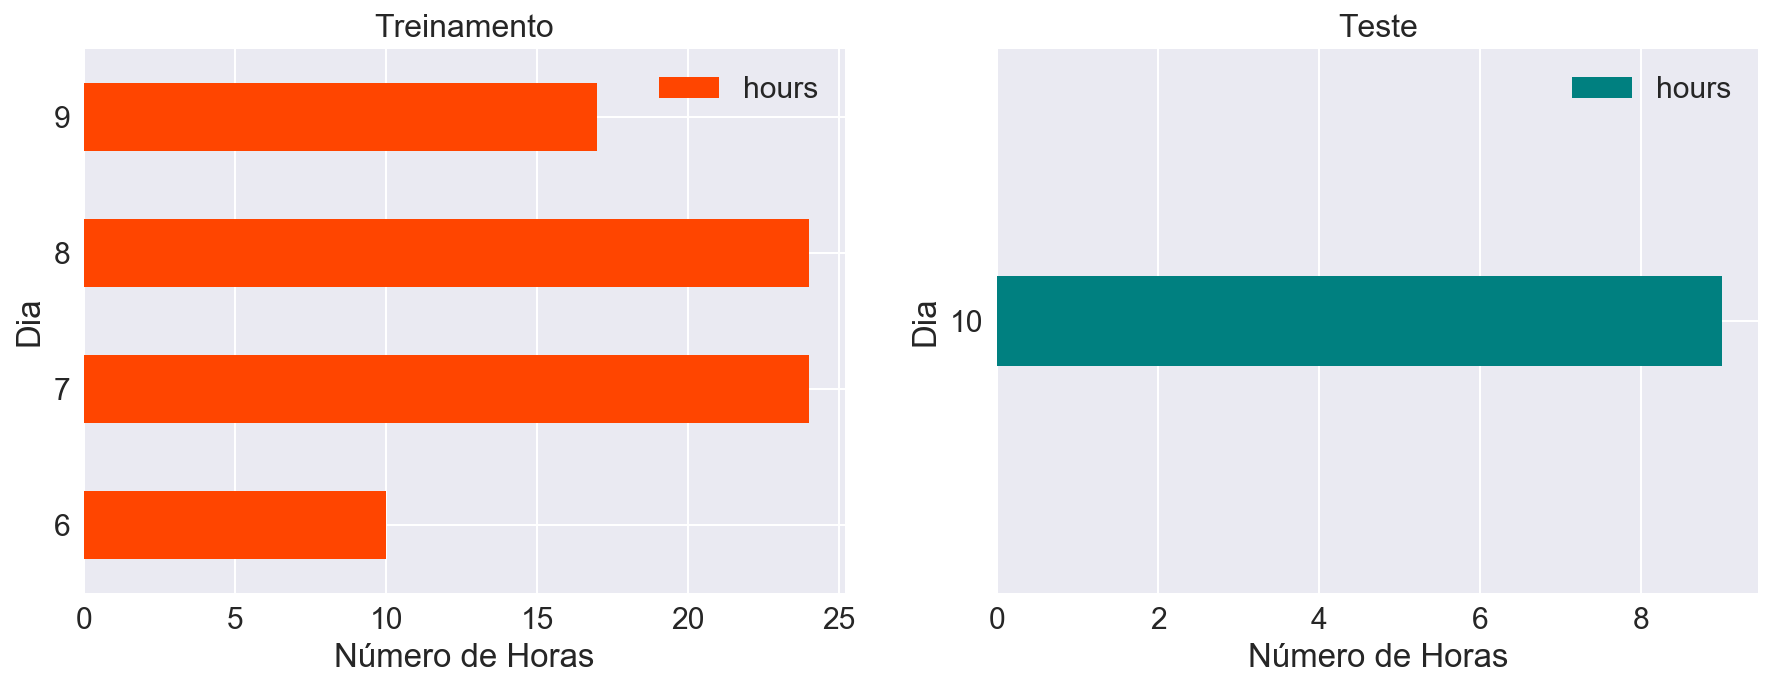

In [104]:
# Plotando os resultados acima
fig, (axs) = plt.subplots(1,2,figsize=(15,5))
day_hour_train.plot(kind = 'barh', ax = axs[0], title = 'Treinamento', 
                    color = 'orangered', width=0.5);
day_hour_test.plot(kind = 'barh', ax = axs[1], title = 'Teste', 
                   color = 'teal', width=0.1,);

axs[0].set_xlabel('Número de Horas');
axs[0].set_ylabel('Dia');
axs[0].title.set_size(16)

axs[1].set_xlabel('Número de Horas');
axs[1].set_ylabel('Dia');
axs[1].title.set_size(16)
sns.despine()

Vemos que os dados de treinamento compreendem os dias 6,7,8 e 9, ao passo que os dados de teste são somente do dia 10. Para os dias 7 e 8, temos observações em todas as horas. Para os dados de teste, temos observações em apenas 9 horas ao longo do dia. A próxima pergunta é: como se distribuem os clicks ao longo do dia?

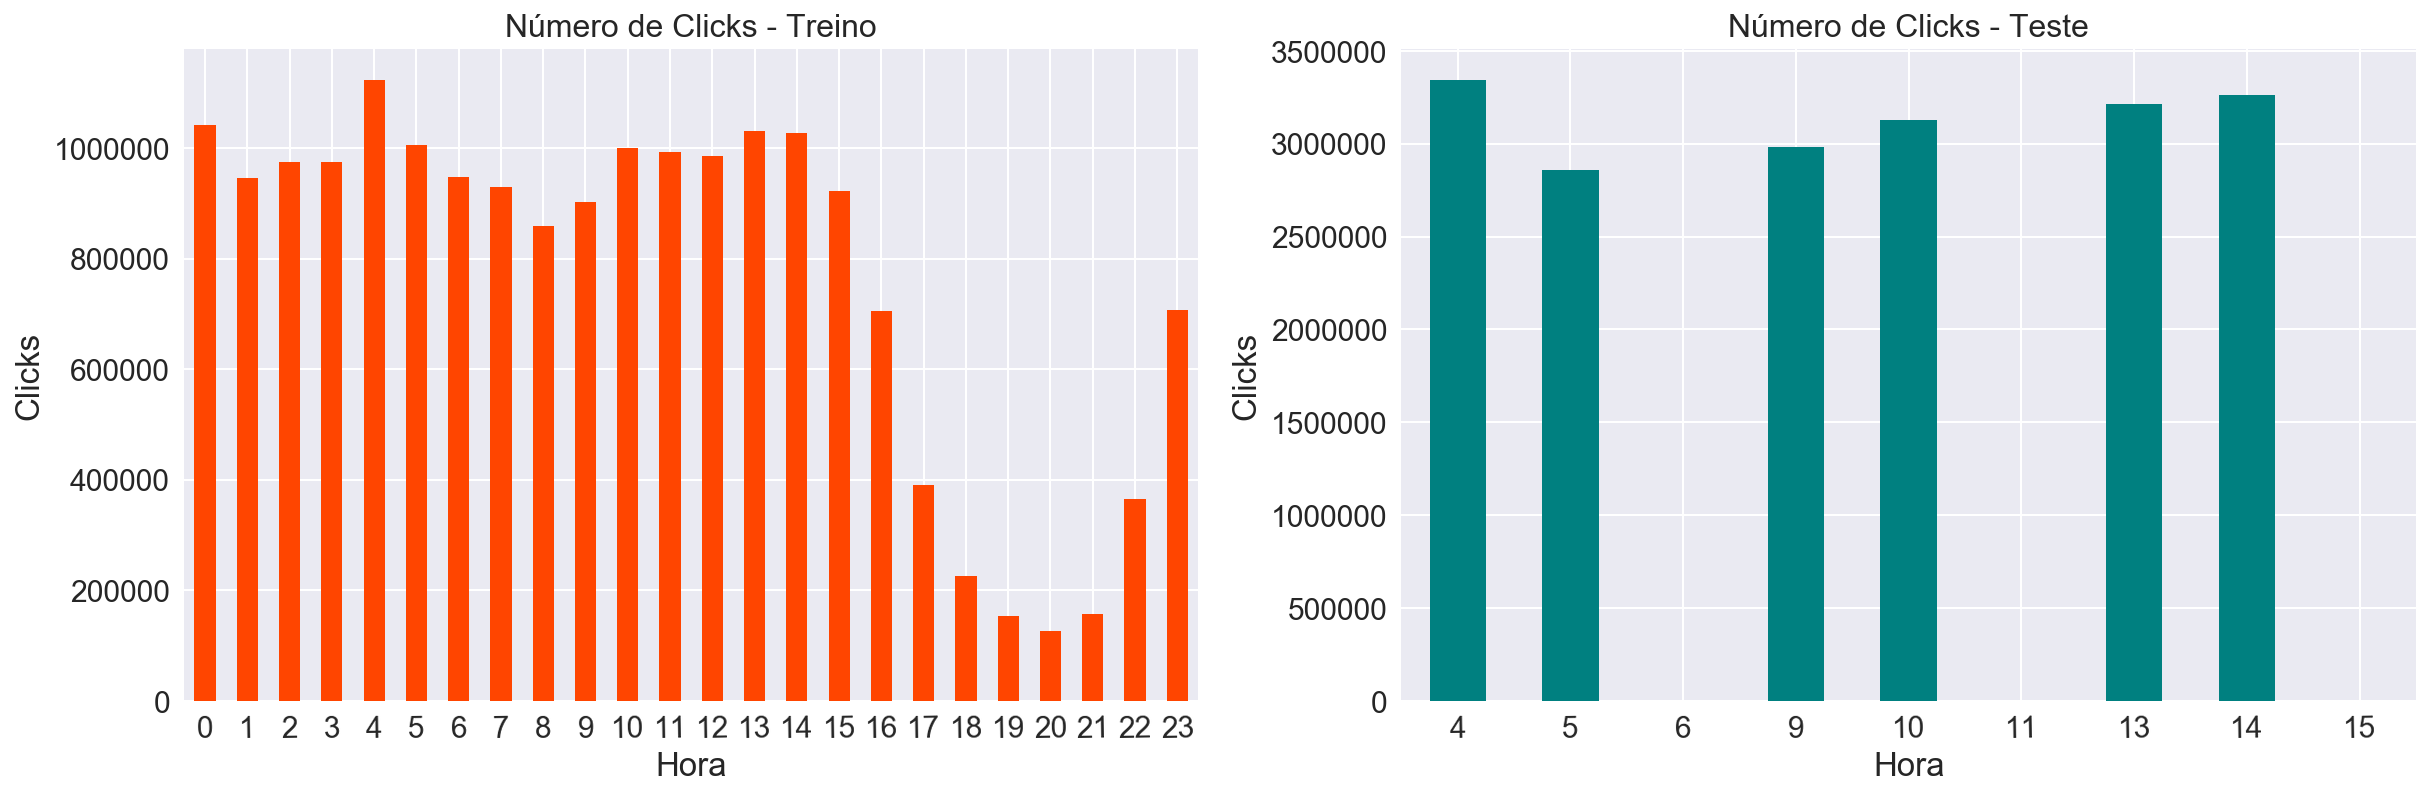

In [105]:
# Plotando número a dispersão de clicks ao longo do dia
fig, axs = plt.subplots(1,2, figsize = (20,6))

# Para os dados de treinamento:
train['hours'].value_counts(sort = False).plot(kind = 'bar', ax = axs[0], color = 'orangered',
                title = 'Número de Clicks - Treino');
axs[0].set_xlabel('Hora');
axs[0].set_ylabel('Clicks');
axs[0].tick_params(axis = 'x', labelrotation = 1)
axs[0].title.set_size(16)

#Para os dados de teste:
test['hours'].value_counts(sort = False).plot(kind = 'bar', ax = axs[1], color = 'teal',
                title = 'Número de Clicks - Teste');
axs[1].set_xlabel('Hora');
axs[1].set_ylabel('Clicks');
axs[1].tick_params(axis = 'x', labelrotation = 1)
axs[1].title.set_size(16)

In [106]:
test['hours'].value_counts(sort = False)

4     3344125
5     2858427
6         381
9     2984808
10    3127993
11        413
13    3212566
14    3261257
15        499
Name: hours, dtype: int64

Nos dados de treino, observamos que a maior parte dos clicks ocorreu do início da madrugada até o fim da tarde. A partir das 16hs, vemos um clara queda no número de cliques, potencialmente o momento em que as pessoas estavam indo de volta para casa ou indo dormir. Enfatizamos que os dias representados nos dados foram dias úteis, ao longo de uma mesma semana em Novembro de 2017. Curiosamente, após as 22hs, o número de cliques volta a subir.

No caso dos dados de teste, não há um padrão claro. Podemos identificar, contudo, que não há um número de cliques expressivos identificados nos dados às 6hs, 11hs e 15hs. Esta afirmação é confirmada pela simples contagem de cliques por hora feita acima. Como visto no gráfico anterior, os dados de teste são mais concentrados em alguns momentos ao longo do dia se comparados aos dados de treinamento.

A pergunta seguinte é de quantos desses clicks são convertidos efetivamente em downloads, no caso dos dados de treinamento.

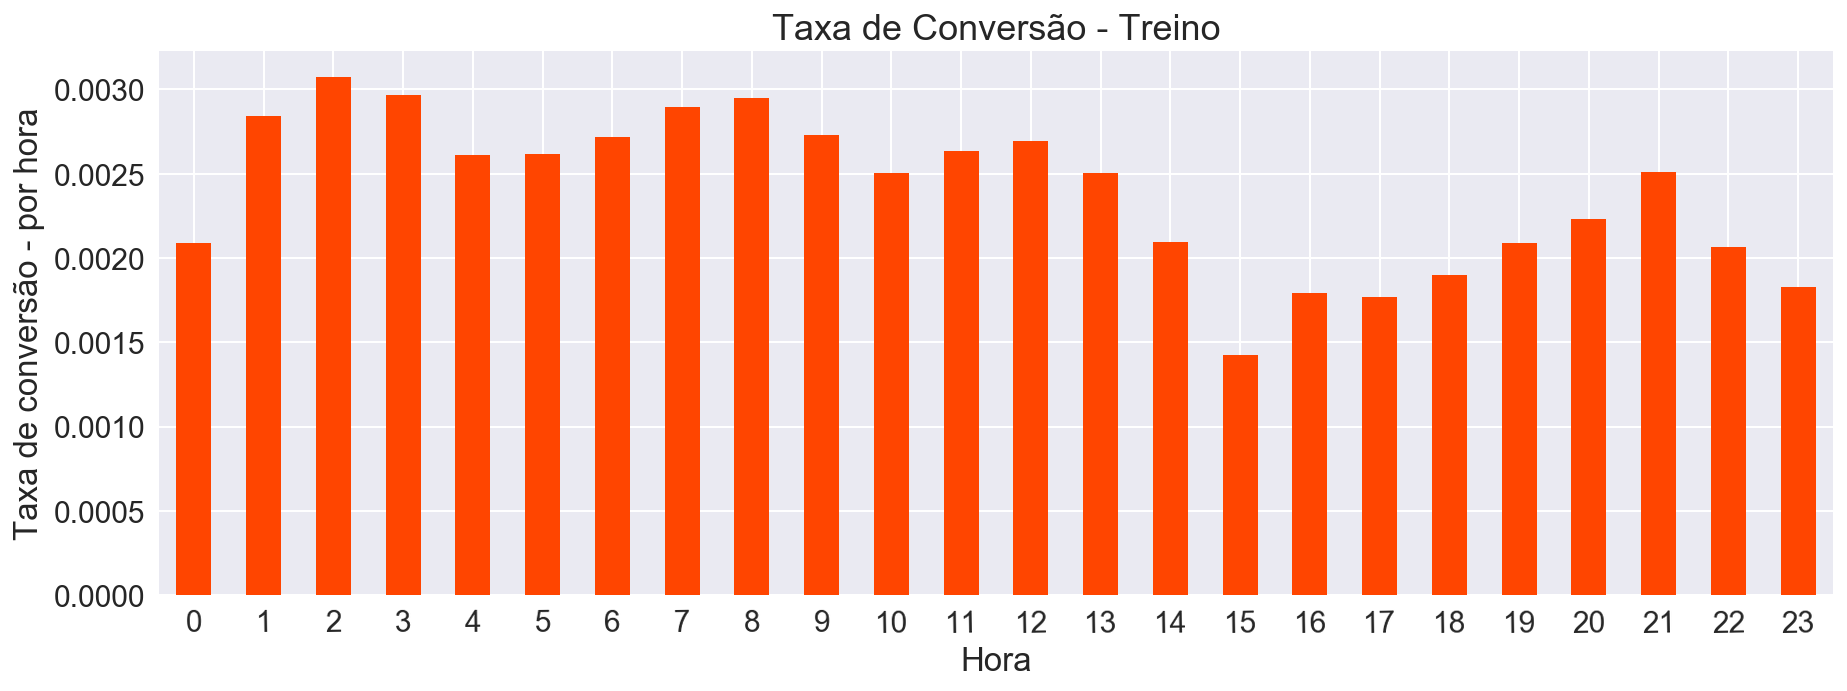

In [107]:
# Plotando a taxa de conversão dos cliques em download a cada hora
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1,1,1)
train[['hours', 'is_attributed']].groupby('hours').agg(np.mean).plot(kind = 'bar', color = 'orangered', 
                                                                   title = 'Taxa de Conversão - Treino', legend = None, ax = ax);
ax.set_xlabel('Hora');
ax.set_ylabel('Taxa de conversão - por hora')
ax.tick_params(axis = 'x', labelrotation = 1)

Notamos que a taxa de conversão ao longo do dia é consistentemente menor que 0.3%! Isto quer dizer que poucos downloads são, de fato, realizados e temos vários clicks em vão. As maiores taxas de conversão são encontradas durante a madrugada, enquanto as menores no meio da tarde.

Será que existe alguma tendência ao longo dos dias?

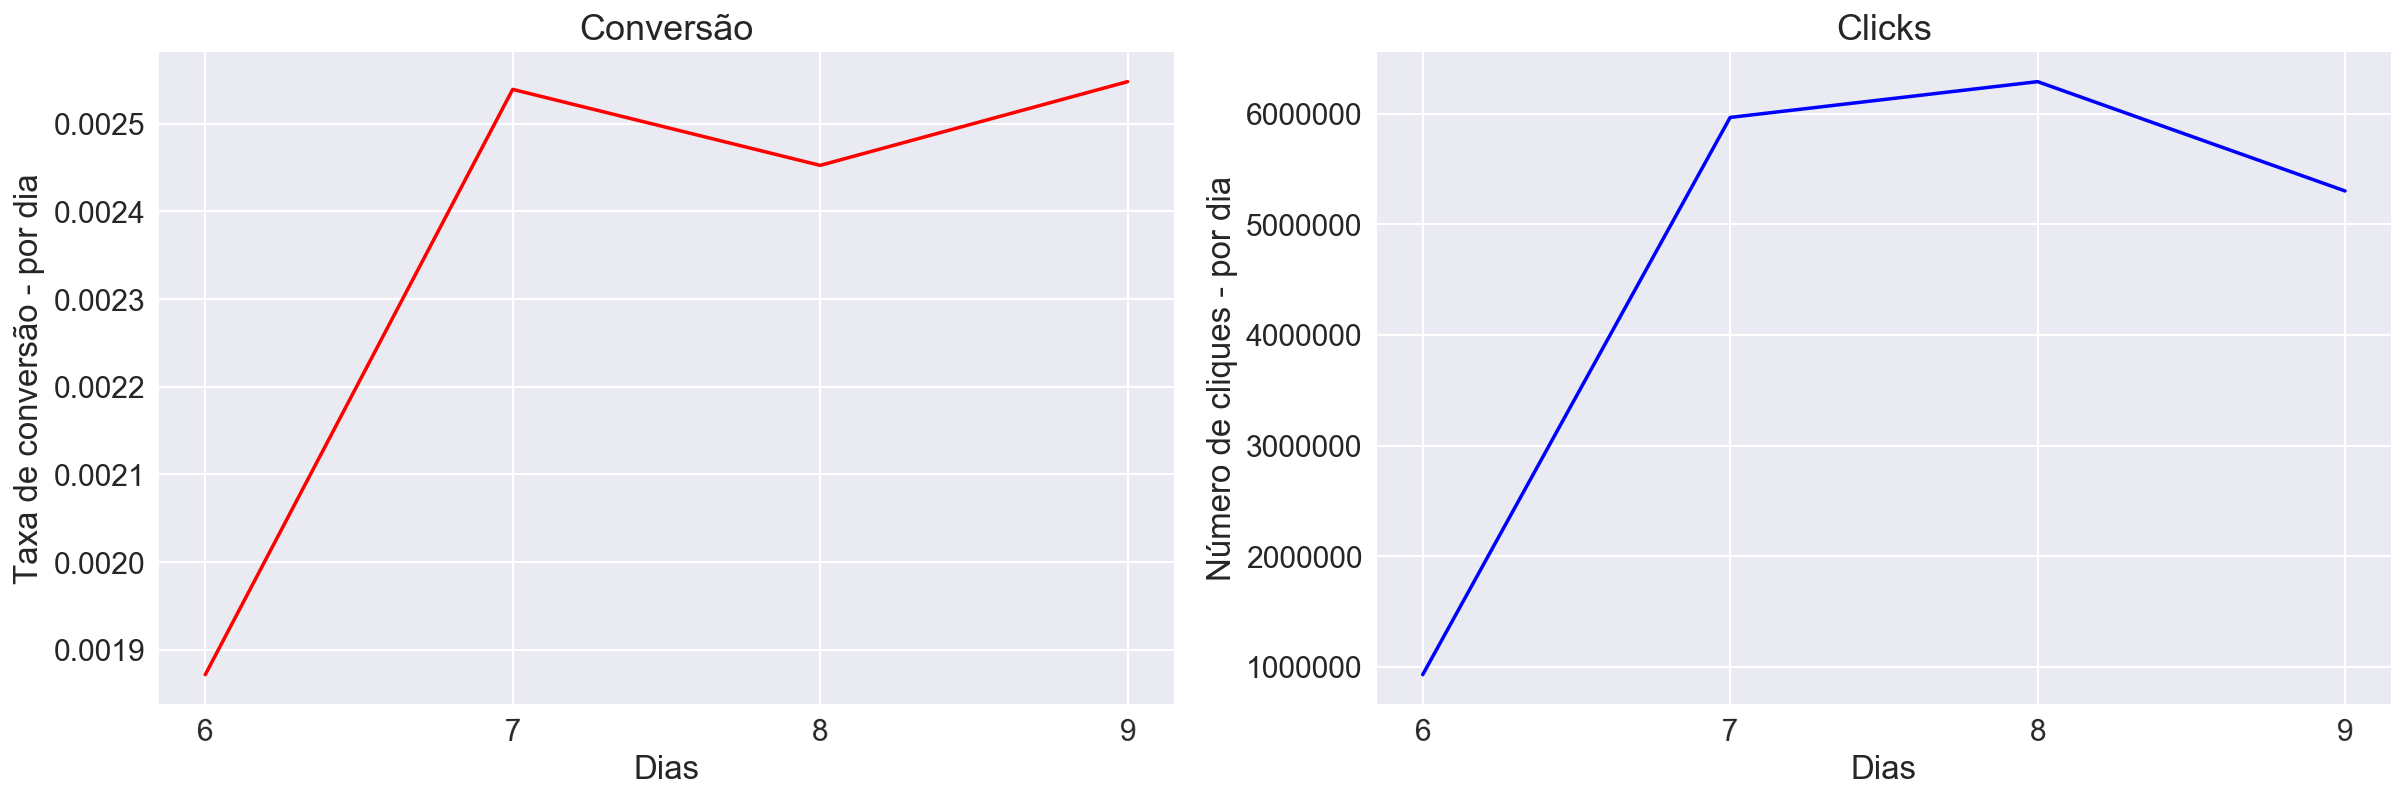

In [108]:
# Buscando uma tendência temporal para a taxa de convesão e número de clicks nos dados de treinamento
fig, axs = plt.subplots(1,2, figsize = (20,6))
df = train[['days', 'is_attributed']].groupby('days').agg([np.mean, 'count'])
df.reset_index()
df['is_attributed']['mean'].plot(kind = 'line', color = 'red', ax = axs[0], title = 'Conversão', legend = None,
                                xticks = [6,7,8,9]);
df['is_attributed']['count'].plot(kind = 'line', color = 'blue', ax = axs[1], title = 'Clicks', legend = None,
                                 xticks = [6,7,8,9]);

axs[0].tick_params(axis = 'x', labelrotation = 1);
axs[0].set_ylabel('Taxa de conversão - por dia');
axs[0].set_xlabel('Dias');

axs[1].tick_params(axis = 'x', labelrotation = 1);
axs[1].set_ylabel('Número de cliques - por dia');
axs[1].set_xlabel('Dias');

Não há nenhum tipo de tendência visível ao longo dos quatro dias nos dados de treinamento. Podemos notar apenas que há muito menos dados para o dia 6 e que a taxa de conversão também foi menor neste dia.

A baixa taxa de conversão sugere um dataset de treinamento desbalanceado, com relativamente poucas observações de fato contabilizadas como downloads.

In [109]:
# Checando se o dataset está realmente desbalanceado
df = train['is_attributed'].value_counts()
print('Número total de clicks: ' + str(df[0]))
print('Número total de downloads: ' + str(df[1]))
print('Razão dowloads/clicks: ' + str((df[1]/df[0])*100) +'%')

Número total de clicks: 18444556
Número total de downloads: 45832
Razão dowloads/clicks: 0.24848524410129472%


Aproximadamente apenas 1 click a cada 400 se converte em download!!! Isto deixa margem para acreditar que algum tipo de fraude esteja ocorrendo.

Vamos analisar se o fluxo de clicks subsequentes na rede é similar para o caso em que há downloads e em que não há.

In [411]:
# Esta funcao calcula uma serie de diferenças de timestamp para cada classe
def total_dif(dataframe, download):
    cols_list = ['ip','is_attributed', 'days', 'hours', 'minutes', 'seconds']
    df = (dataframe[cols_list][dataframe['is_attributed'] == download]).sort_values(by = ['days', 'hours', 'minutes', 'seconds'])
    df['min_dif'] = df['minutes'] - df['minutes'].shift(1)
    df['hour_dif'] = df['hours'] - df['hours'].shift(1)
    df['s_dif'] = df['seconds'] - df['seconds'].shift(1)
    df['day_dif'] = df['days'] - df['days'].shift(1)
    df['total_dif'] = df['day_dif']*24*3600 + df['hour_dif']*3600 + df['min_dif']*60 + df['s_dif']
    series = df['total_dif']
    del df
    return series

In [412]:
# Computando as diferenças de timestamp
train['total_dif_1'] = total_dif(train, 1)
train['total_dif_0'] = total_dif(train, 0)

In [334]:
train.head()

,ip,app,device,os,channel,is_attributed,days,hours,minutes,seconds,total_dif_1,total_dif_0
0,103022,3,1,23,379,0,6,14,37,44,NaN,NaN
1,114221,3,1,19,379,0,6,14,37,59,NaN,15.0
2,47902,3,1,17,379,0,6,14,48,7,NaN,608.0
3,23550,3,1,13,379,0,6,14,53,39,NaN,332.0
4,84644,3,1,19,379,0,6,14,56,49,NaN,190.0


In [335]:
# Analisando graficamente com Bokeh
from bokeh.plotting import figure, output_file, show, output_notebook

p = figure(plot_width = 800, plot_height = 500, title = 'Densidade/Esparsidade dos clicks',
          x_axis_label = 'Ordenamento Cronológico dos clicks', y_axis_label = 'Diferença de timestamps (segundos)', 
           y_range=(0,250))

x1 = train['total_dif_1'][train['total_dif_1'].notnull()].index
y1 = train['total_dif_1'][train['total_dif_1'].notnull()].values

# Nao plotamos todos os elementos da serie de fraudes pois o kernel do jupyter começar a reclamar por conta da memória!
x0 = train['total_dif_0'][train['total_dif_0'].notnull()].index[1:-1:40000]
y0 = train['total_dif_0'][train['total_dif_0'].notnull()].values[1:-1:40000]

p.circle(x = x1, y = y1, size = 3, color = 'blue', alpha = 0.3, legend = 'Downloads')
p.circle(x = x0, y = y0, size = 5, color = 'red', alpha = 0.9, legend = 'Fraudes')

output_notebook()
show(p)

Loading BokehJS ...

O gráfico acima é alarmante. Nele, podemos ver duas características inesperadas dos dados:
1. Os cliques classificados como fraudulentos ocorrem em alta frequência, isto é, há uma diferença negligenciável entre os timestamps de clicks fraudulentos consecutivos. Este tipo comportamento dá força à hipótese de existência de bots criando clicks que não levam a downloads. Por outro lado, os downloads são muito mais espaçados, ou seja, ocorrem em menor frequência. Esta observação sugere que um modelo preditivo deveria levar em conta não somente o momento do click atual mas, se possível, também o tempo decorrido desde o último click.
2. Há uma periodicidade no caso dos downloads. A diferença de timestamp entre downloads consecutivos é estável na maior parte do tempo, ao redor de 20 segundos. Contudo, há *spikes* nos dados: momentos em que a diferença de tempo entre downloads consecutivos torna-se maior e parece que estes *spikes* ocorrem periodicamente.

O comportamento periódico talvez seja melhor entendido se olharmos para os downloads que mais "se atrasaram":

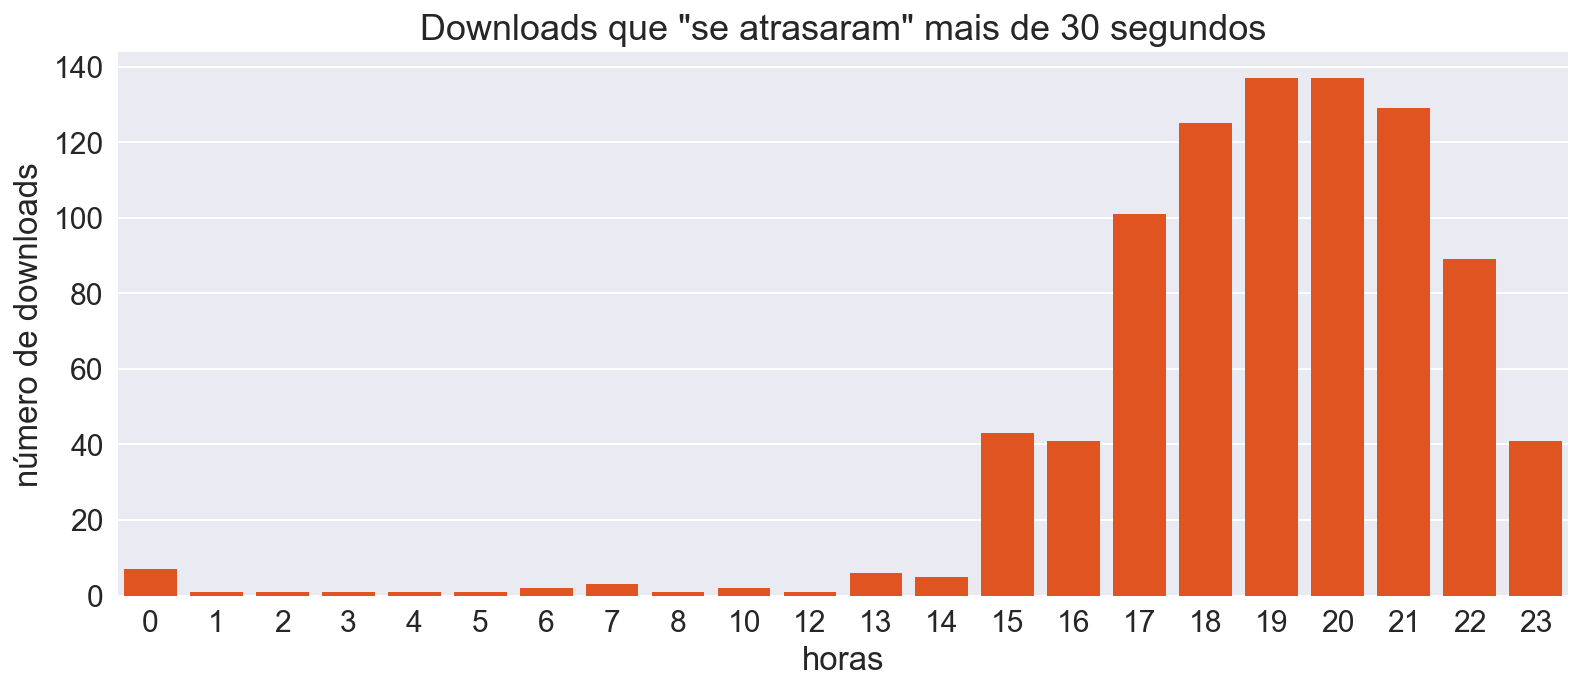

In [414]:
limit = 30;
lazy_ones = train[train['total_dif_1'] > limit][['total_dif_1', 'hours']].groupby('hours').agg('count')
lazy_ones.index.name = 'horas'
lazy_ones.columns = ['número de downloads']
fig, axs = plt.subplots(figsize = (13,5))
sns.barplot(x = lazy_ones.index, y = 'número de downloads', data = lazy_ones, hue = None, color = 'orangered',
                 ax = axs);
axs.set_title('Downloads que "se atrasaram" mais do de ' + str(limit) + ' segundos');

Considerando, por exemplo, apenas os downloads que demoraram mais do que 30 segundos para serem requisitados desde o último download registrado, vemos que há um desbalanceamento: eles ocorrem muito mais frequentemente entre o início da tarde e meia-noite. Isto explica o padrão cíclico visto de Densidade/Esparsidade dos clicks.

É curioso notar que este período coincide com o período de menor número de clicks, já indicado num gráfico anterior. Conjuntamente com a informação de que os clicks fraudulentos ocorrem em alta frequência de maneira uniforme, é razoável propor a seguinte linha geral de interpretação. Durante o fim da tarde e o início da madrugada, os usuários reais (que de fato fazem os downloads!) estão saindo do trabalho e engajando-se em atividades em que o uso de aparelhos eletrônicos é menos frequente: dirigindo no trânsito, cozinhando o jantar e conversando com a família, etc. O número de clicks cai e os downloads tornam-se mais *esparsos* pois há menos usuários ativos. Contudo, os cliques fraudulentos não exibem este comportamento, provavelmente porque são originários de bots. Isto está em linha também com a menor taxa de conversão observada no período.

Resumo: os bots não precisam parar de trabalhar e nem tem famílias!!!!

In [339]:
# Otimizando memória
del train['total_dif_1']
del train['total_dif_0']
gc.collect();

### IP's
Podemos analisar os ips para entender melhor estes clicks.

In [349]:
# Checando se há ips repetidos
train_set = set(train.ip)
test_set = set(test.ip)
inter = train_set.intersection(test_set)
p = len(inter)/len(train_set)
q = len(inter)/len(test_set)
print('Número de IPs únicos no dado de Treino (10%): ' + str(len(train_set)))
print('Número de IPs únicos no dado de Teste: ' + str(len(test_set)))
print('IPs na Interseção: ' + str(len(inter)))
print('Total de IPs da Interseção sobre IPs de Treino: ' + str(round(p*100, 2)) + '%')
print('Total de IPs da Interseção sobre IPs de Teste: ' + str(round(q*100, 2)) + '%')

Número de IPs únicos no dado de Treino (10%): 175900
Número de IPs únicos no dado de Teste: 93936
IPs na Interseção: 37689
Total de IPs da Interseção sobre IPs de Treino: 21.43%
Total de IPs da Interseção sobre IPs de Teste: 40.12%


Curiosamente, há relativamente poucos IPs gerando mais de 18 milhões de clicks. Podemos analisar esta relação mais a fundo.

In [404]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', 
                                                                                             ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', 
                                                                                          ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'clicks', 'prop']
merge['downloads'] = merge['clicks']*merge['prop']

In [356]:
merge.head()

,ip,clicks,prop,downloads
0,5348,123470,0.001855,229.0
1,5314,117347,0.001934,227.0
2,73516,77004,0.001467,113.0
3,73487,76840,0.001510,116.0
4,53454,49921,0.000300,15.0


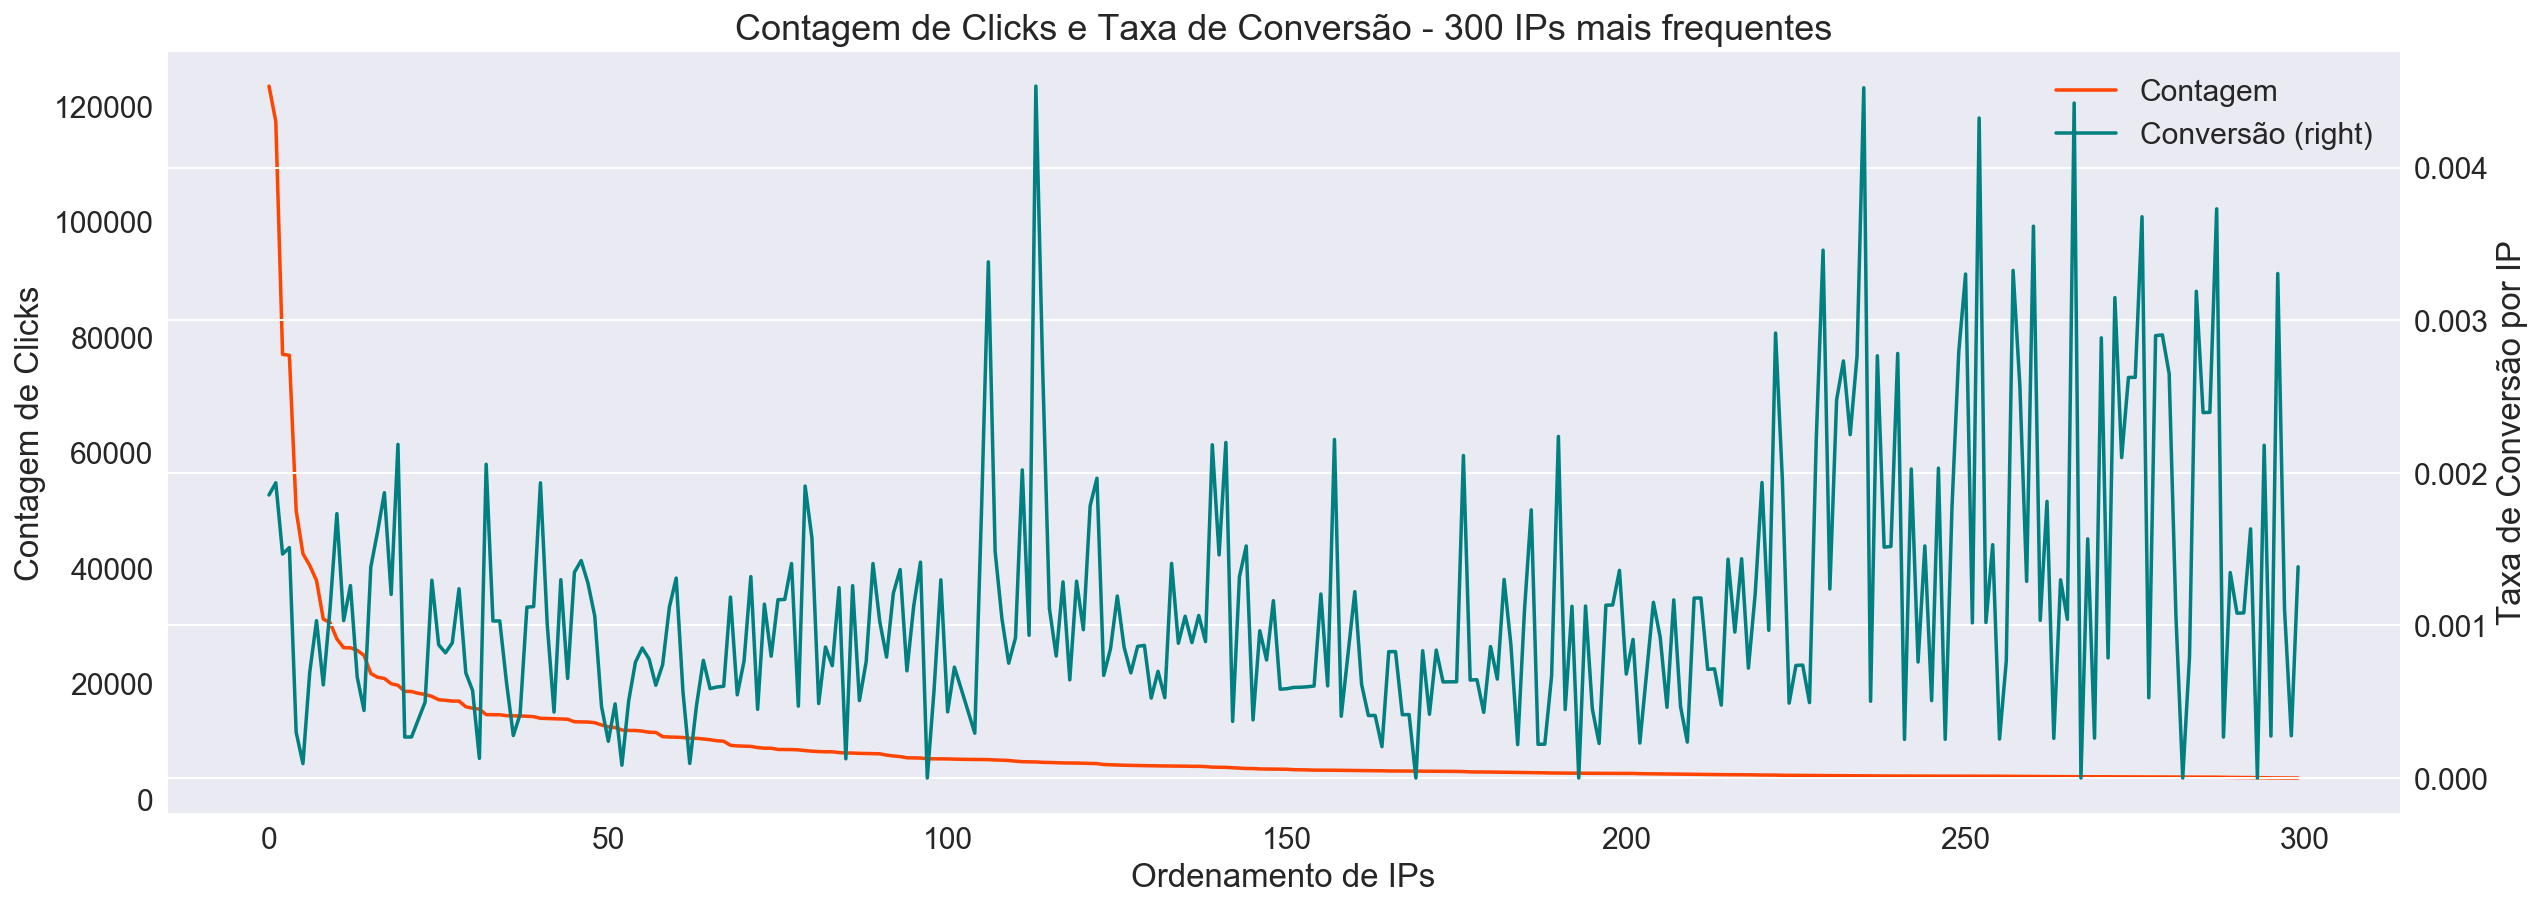

In [405]:
# Plotando o número de clicks e a proporção de downloads (Taxa de Conversão por IP)
limit = 300
ax1 = merge.clicks[:limit].plot(figsize = (20,7), color = 'orangered', legend = True, label = 'Contagem')
ax2 = merge.prop[:limit].plot(color = 'teal', secondary_y = True, legend = True, label = 'Conversão')
ax1.set(title = 'Contagem de Clicks e Taxa de Conversão - ' + str(limit) + ' IPs mais frequentes', 
        xlabel = 'Ordenamento de IPs', ylabel = 'Contagem de Clicks');
ax2.set(ylabel = 'Taxa de Conversão por IP');

Fica claro que alguns IPs são responsáveis por um tráfego desproporcionalmente grande na rede, gerando muitos registros. Entretanto, isto não está diretamente correlacionado com uma alta taxa de conversão. Ao contrário, a taxa de conversão parece maior na extrema direita do gráfico. Uma outra visualização pode ser feita com o gráfico abaixo:

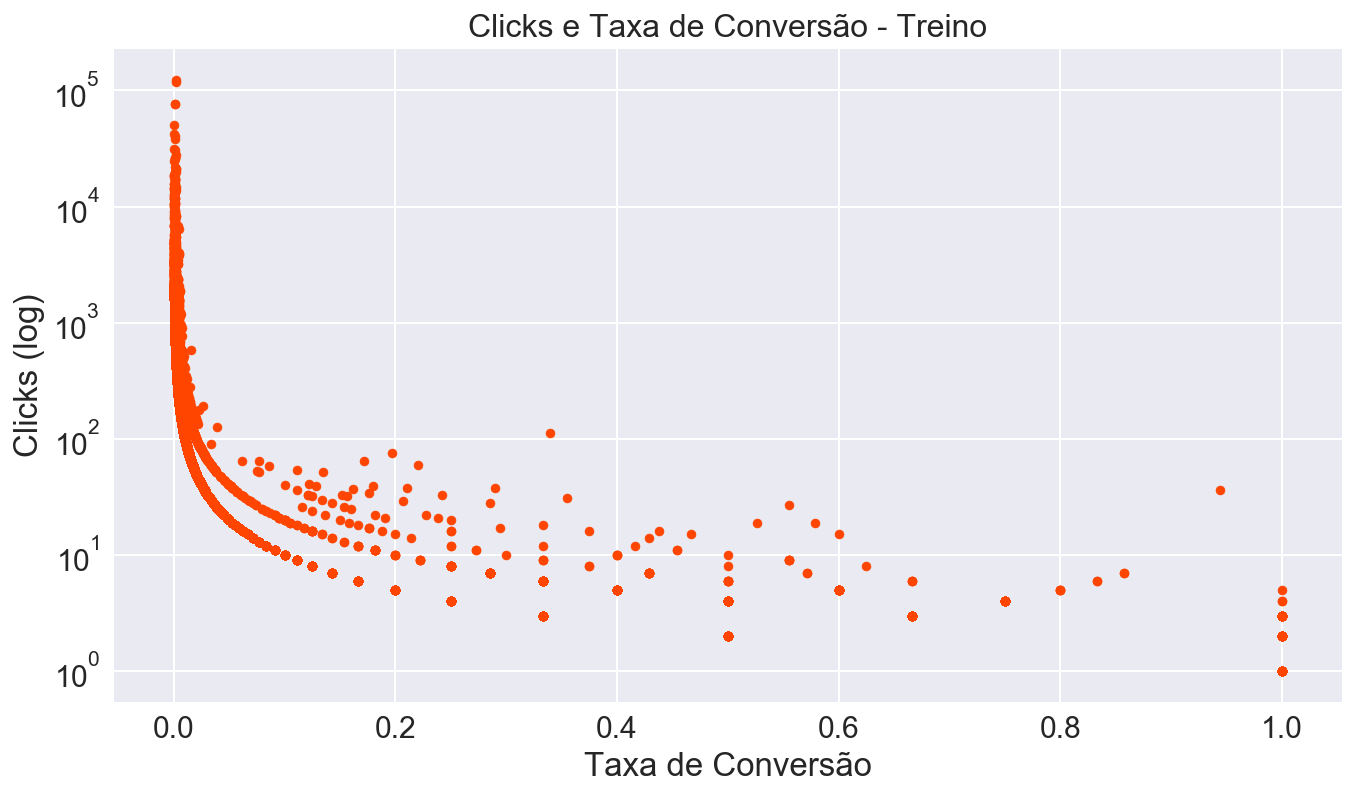

In [409]:
fig = merge[merge['prop'] > 0].plot(kind = 'scatter', x = 'prop', y = 'clicks', color = 'orangered', figsize = (11,6), 
                        logy = True)

fig.set_ylabel('Clicks (log)');
fig.set_xlabel('Taxa de Conversão');
fig.set_title('Clicks e Taxa de Conversão - Treino', fontsize=16);

A visualização acima não deixa dúvidas: há uma forte relação inversa entre a taxa de conversão e número de clicks (consideramos neste segundo gráfico apenas ips que registraram algum download de fato). Checamos agora como a distribuição de clicks de treino se compara com a distribuição dos dados de teste.

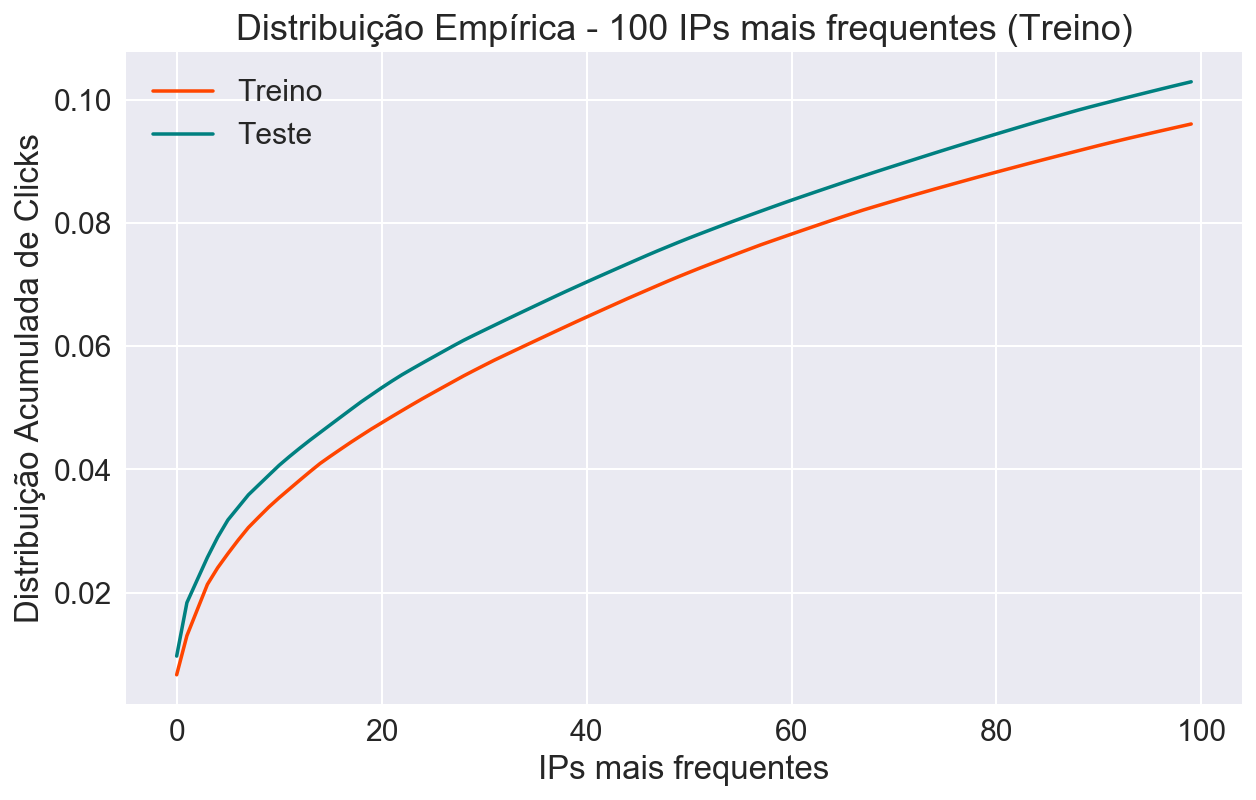

In [408]:
merge['cumulative'] = merge.clicks.cumsum()/train.ip.count()

limit = 100
plt.figure(figsize = (10,6))
plt.plot(merge.cumulative[:limit], color = 'orangered', label = 'Treino')
plt.xlabel('IPs mais frequentes')
plt.ylabel('Distribuição Acumulada de Clicks')
plt.title('Distribuição Empírica - ' + str(limit) + ' IPs mais frequentes (Treino)')

total = test.ip.count()
m = test.ip.value_counts().reset_index()['ip'].cumsum()/total
plt.plot(m[:limit], color = 'teal', label = 'Teste')

plt.legend()
plt.show()

Plotamos a distribuição acumulada empírica de clicks. No eixo X, temos uma ordenação dos IPs mais frequentes. Podemos observar que os 100 ips mais frequentes nos dados de Treinamento representam quase 10% dos clicks totais, o que também ocorre no caso dos dados de Teste. Se olharmos para os 2000 IPs mais frequentes, este número sobe para mais de 30%. Parece ser o caso em que devêssemos implementar, num modelo preditivo, algum tipo de *blacklist* por ip.

A distribuição empírica dos dados de Treino se coloca consistentemente abaixo da distribuição de Teste. Isto implica que a característica de ter poucos IPs representando larga parcela dos clicks totais é mais exacerbada no caso dos dados de Teste.

### Outras features
Analisamos a seguir as features *os*, *app*, *device* e *channel*.

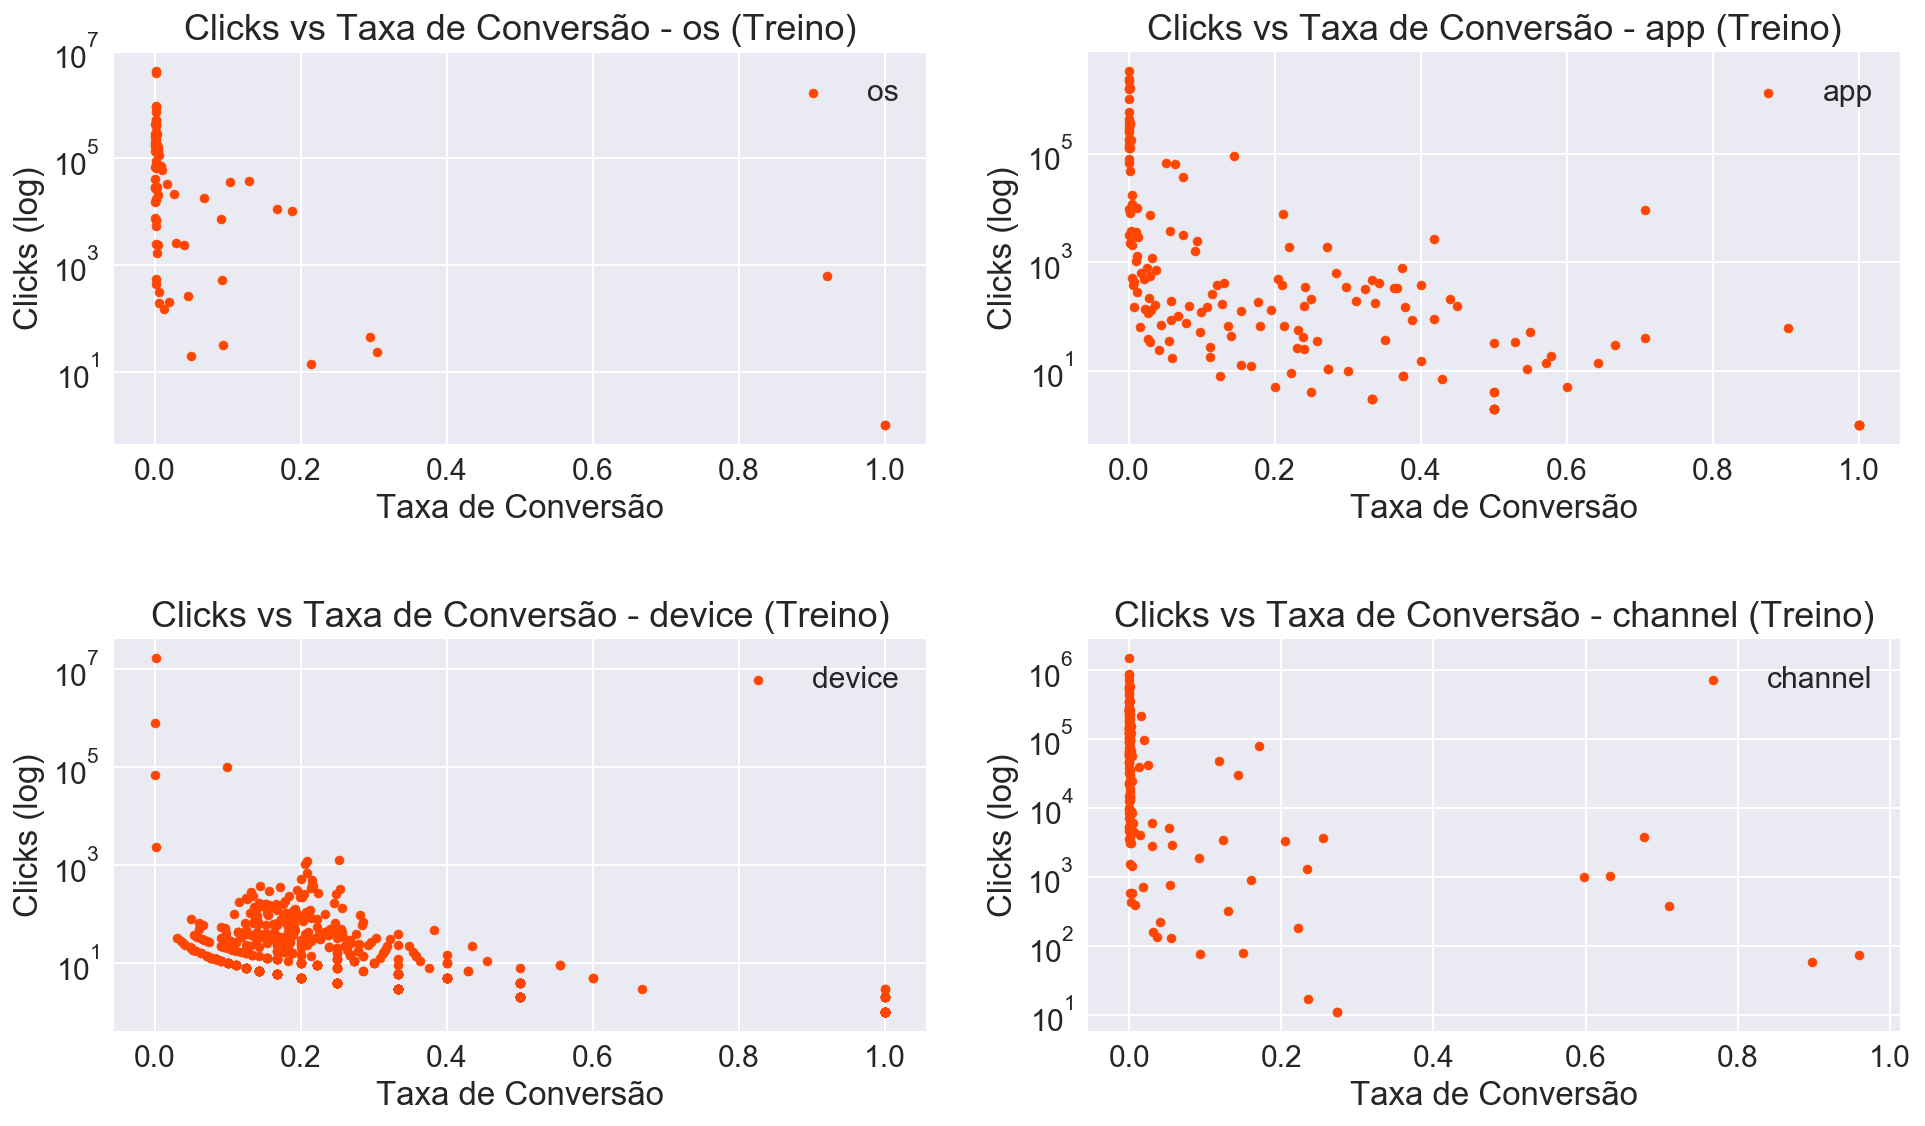

In [402]:
features = ['os', 'app', 'device', 'channel']
fig, axs = plt.subplots(2,2, figsize = (16,9))
tuples = [(0,0), (0,1), (1,0), (1,1)]
plt.subplots_adjust(hspace = 0.5)

for idx, f in enumerate(features):
    proportion = train[[f, 'is_attributed']].groupby(f, as_index=False).mean().sort_values('is_attributed', 
                                                                                             ascending=False)
    counts = train[[f, 'is_attributed']].groupby(f, as_index=False).count().sort_values('is_attributed', 
                                                                                          ascending=False)
    merge = counts.merge(proportion, on= f , how='left')
    merge.columns = [f , 'clicks', 'prop']
    merge[merge.prop > 0].plot(kind = 'scatter', x = 'prop', y = 'clicks', color = 'orangered', 
                        logy = True, ax = axs[tuples[idx]], label = f, legend = True)
    axs[tuples[idx]].set_ylabel('Clicks (log)');
    axs[tuples[idx]].set_xlabel('Taxa de Conversão');
    axs[tuples[idx]].set_title('Clicks vs Taxa de Conversão - ' + str(f) + ' (Treino)')
    
gc.collect();

Qualitativamente, observamos o mesmo comportamento destas features com relação à dinâmica de clicks e taxa de conversão. Há uma relação inversa entre gerar muitos clicks e transformar clicks em downloads. Esta tendência é menos pronunciada em *device*, contudo. Este resultado persiste ainda que consideremos somente os casos em que determinada categoria de uma feature gera ao menos algum download.

Em conjunto com a dinâmica já observada dos IPs, este tipo de relação aponta para a possibilidade de uma estratégia preditiva baseada em *blacklists* ser bem sucedida.